In [5]:

# Code for N-fold pendulum; works only up to N=3
# afterwards solving equations for accelerations takes too long
# no solution was obtained because simulation was aborted after some time; it theoretically works for N>3 but can not be confirmed

# ------------------------------------------------------------------------------------------------------------------------ #

# import all necessary packages
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib

import sys
import traceback

from scipy.integrate import solve_ivp

import time

from sympy.physics.mechanics import *

# ------------------------------------------------------------------------------------------------------------------------ #

def check_variable_name(variable_name):
    """
    Checks if the provided variable_name is in the correct format of string

    Args:
        variable_name (str): the name of the variable that should be used in the script; preferably greek letter because gets used in latex later on

    Returns:
        None
        
    """
    if isinstance(variable_name, str) == True:
        print("variable_name is in the right format of str")
    else:
        msg="variable_name is in the wrong format; please change to str"
        sys.exit(msg)
    
def check_length_array(array, N):
    """
    Checks the length of the provided list called array with the variable N which is the number of pendulums (degrees of freedom)

    Args:
        array (list): list that should be ched for the correct length
        N (int): number of pendulums

    Returns:
        None
        
    """
    name_array = [name for name, value in globals().items() if value is array][0]
    
    if len(array) == N:
        print("Array length of", name_array, "(", len(array), ") matches N (", N, ")")
    else:
        msg = "Array length of " + name_array + " ( " + str(len(array)) + " ) does not match N ( " + str(N) + " )"
        sys.exit(msg)

def check_parameters_format(parameter, array):
    """
    Checks if the provided parameter called parameter is the right type of int or float

    Args:
        parameter (float, int): parameter to check for type
        array (list): list from which type is extracted

    Returns:
        None
        
    """
    format = str(type(parameter)).split("'")[1]
    variable_name = [name for name, value in globals().items() if value is array][0]
    
    if isinstance(parameter, (int, float)) == True:
        print("Parameter", variable_name, "=", parameter, "is in the right format of", format)
    else:
        #print("Parameter", variable_name, "=", parameter, "is in the wrong format of", format)
        msg="Parameter "+variable_name+" = "+parameter+" is in the wrong format of "+format
        sys.exit(msg)

def check_array_format(array, N):
    """
    Checks the correct format of a provided list called array; calls check_parameter_format for every entry of list

    Args:
        array (list): list to check the entries for correct format of int or float
        N (int): number of pendulums

    Returns:
        None
        
    """
    for i, val in enumerate(array):
        parameter = array[i]
        check_parameters_format(parameter, array)

def deg_to_rad(phi, array):
    """
    Takes an angle or angular velocity called phi defined in degree or degree/s and transform it to rad or rad/s

    Args:
        phi (float, int): angle or angular velocity to convert
        array (list): used to extract name of provided parameter from name of list

    Returns:
        phi_rad (float, int): converted angle or angular velocity in rad or rad/s
        
    """
    variable_name = [name for name, value in globals().items() if value is array][0]
    phi_rad = phi*(np.pi/180)
    print("Parameter", variable_name, "=", phi, "in degrees was transformed to", phi_rad, "in rad")
    return phi_rad
    
def array_angular_conversion(array, N):
    """
    Takes a list called array and transform each entry from deg or deg/s to rad or rad/s; calls deg_to_rad for every entry

    Args:
        array (list): list to convert
        N (int): number of pendulums

    Returns:
        array_rad (list): converted list
        
    """
    array_rad = []
    for i, val in enumerate(array):
        parameter = array[i]
        parameter_rad = deg_to_rad(parameter, array)
        array_rad.append(parameter_rad)
    return array_rad

def create_params(array, N):
    """
    Creates N symbols for provided parameters in list called array

    Args:
        array (list): list with parameters for which symbolic characters should be produced
        N (int): number of pendulums

    Returns:
        params_array (list): list with symbolic parameters as entries
        
    """
    variable_name = [name for name, value in globals().items() if value is array][0]
    type_array = variable_name.split("_")[0]
    params_array = []
    for i in range(N):
        index = str(i+1)
        name_full = type_array + index
        name_full = sp.symbols(name_full)
        params_array.append(name_full)
    return params_array

def create_variables_and_derivatives(variable_name, N):
    """
    Creates N symbolic variables with name of variable_name; furthermore calculates first and second derivative with respect to time

    Args:
        variable_name (str): name of variable that should be used in the script
        N (int): number of pendulums

    Returns:
        variable_array (list): list with symbolic variables of length N
        derivative_array(list): list with first and second derivatives as symbolic variables; length of list is 2*N; alternating between first and second derivative
        
    """
    variable_t = variable_name + "t"
    variable_array = []
    derivative_array = []
    for i in range(N):
        index = str(i+1)
        name_full = variable_t + index
        name_final = sp.Function(name_full)(t)
        func_dt = name_final.diff(t)
        func_ddt = name_final.diff(t, 2)
        variable_array.append(name_final)
        derivative_array.append(func_dt)
        derivative_array.append(func_ddt)  
    return variable_array, derivative_array

def create_x_and_y(N):
    """
    Creates N variables for x and y coordinates; variables dependant from time

    Args:
        N (int): number of pendulums

    Returns:
        x_array (list): list of symbolic x variables in list of length N
        y_array (list): list of symbolic y variables in list of length N
        
    """
    x_array = []
    y_array = []
    for i in range(N):
        index = str(i+1)
        x_name_full = "x" + index
        y_name_full = "y" + index
        x_name_final = sp.Function(x_name_full)(t)
        y_name_final = sp.Function(y_name_full)(t)
        x_array.append(x_name_final)
        y_array.append(y_name_final)
    return x_array, y_array

def create_xn_and_yn(params_l, x_variables, y_variables, N):
    """
    Creates symbolic representation for each x and y for every pendulum in dependence of the lengths and the angles in the list variables
    In this case x-axis is horizontally (positive values to the right) and y-axis vertically (positive values to the bottom)

    Args:
        params_l (list): list of parameter values for length l
        x_variables (list): list with symbolic x variables
        y_variables (list): list with symbolic y variables

    Returns:
        xn_variables (list): list of symbolic representation of each xn for every pendulum n
        yn_variables (list): list of symbolic representation of each yn for every pendulum n
        
    """
    xn_variables = x_variables
    yn_variables = y_variables
    for i in range(N):
        x_loop = x_variables[i]
        y_loop = y_variables[i]
        x_ph_loop = x_loop
        y_ph_loop = y_loop
        for o in range(i+1):
            x_ph = params_l[o]*sp.sin(variables[o])
            y_ph = params_l[o]*sp.cos(variables[o])
            x_ph_loop = x_ph_loop + x_ph
            y_ph_loop = y_ph_loop + y_ph
        xn_variables[i] = x_ph_loop - x_loop
        yn_variables[i] = y_ph_loop - y_loop
    return xn_variables, yn_variables

def create_T(params_m, g, xn_variables, yn_variables, N):
    """
    Creates kinetic energy T for N pendulums; hard coded for this type of system
    Here xn and yn values for each pendulum are differentiated to get velocities; with them construct T

    Args:
        params_m (list): list with symbolic parameters for all m
        g (symbolic): symbolic parameter for g
        xn_variables (list): list of symbolic representation of each xn for every pendulum n
        yn_variables (list): list of symbolic representation of each yn for every pendulum n
        N (int): number of pendulums

    Returns:
        T (symbolic): symbolic expression for kinetic energy T
        
    """
    T_ph = params_m[0]
    T_loop = T_ph
    for i in range(N):
        xnd_variables = xn_variables[i].diff(t)
        ynd_variables = yn_variables[i].diff(t)
        subst_term = 0.5*params_m[i]*(xnd_variables**2+ynd_variables**2)
        T_loop = T_loop + subst_term
    T = T_loop - T_ph
    print("Kinetic energy T is:", T)
    print("")
    return T

def create_U(params_m, params_l, g, yn_variables, N):
    """
    Creates potential energy U for N pendulums; hard coded for this type of system

    Args:
        params_m (list): list with symbolic parameters for all m
        params_l (list): list with symbolic parameters for all l
        g (symbolic): symbolic parameter for g
        yn_variables (list): list of symbolic representation of each yn for every pendulum n
        N (int): number of pendulums

    Returns:
        U (symbolic): symbolic expression for potential energy U
        
    """
    U_ph = params_m[0]
    U_loop = U_ph
    for i in range(N):
        length_step_i = U_ph
        for o in range(i+1):
            length_step_i = length_step_i + params_l[o]
        subst_term = params_m[i]*g[0]*((length_step_i-U_ph)-yn_variables[i])
        U_loop = U_loop + subst_term
    U = U_loop - U_ph
    print("Potential energy U is:", U)
    print("")
    return U

def replace_variable_name(variable_name, L_latex, U_latex, T_latex, LM_M_latex, LM_F_latex, LM_Eq_latex, N):
    """
    Replaces certain strings of characters with the correct encoding for latex to interpret it
    Iterates N-times over all strings and replaces a certain string of characters in each round

    Args:
        variable_name (str): name of variable that should be used in the script
        L_latex (str): str in latex syntax with errors
        U_latex(str): str in latex syntax with errors
        T_latex (str): str in latex syntax with errors
        LM_M_latex (str): str in latex syntax with errors
        LM_F_latex (str): str in latex syntax with errors
        LM_Eq_latex (str): str in latex syntax with errors
        N (int): number of pendulums

    Returns:
        L_latex (str): str in latex syntax; corrected
        U_latex(str): str in latex syntax; corrected 
        T_latex (str): str in latex syntax; corrected 
        LM_M_latex (str): str in latex syntax; corrected
        LM_F_latex (str): str in latex syntax; corrected 
        LM_Eq_latex (str): str in latex syntax; corrected 
        
    """
    for i in range(N):
        act_name = "operatorname{" + variable_name + "t}_{" + str(i+1) + "}"
        new_name = variable_name + "_{" + str(i+1) + "}"
        L_latex = L_latex.replace(act_name, new_name)
        U_latex = U_latex.replace(act_name, new_name)
        T_latex = T_latex.replace(act_name, new_name)
        LM_M_latex = LM_M_latex.replace(act_name, new_name)
        LM_F_latex = LM_F_latex.replace(act_name, new_name)
        LM_Eq_latex = LM_Eq_latex.replace(act_name, new_name)
    return L_latex, U_latex, T_latex, LM_M_latex, LM_F_latex, LM_Eq_latex

def calculate_Lagrange_Equations(L, variable_name, t, N):
    """
    Calculates Lagrange Equations from Lagrangian L; calculates intermediate results through derivatives
    Calculates final expressions from subterms and saves each equation as a list entry

    Args:
        L (symbolic): symbolic representation of Lagrangian
        variable_name (str): name of variable that should be used in the script
        t (symbolic): symbolic variable for time
        N (int): number of pendulums

    Returns:
        Eq (list): list of symbolic Lagrange Equations
        
    """
    Eq = []
    for i in range(N):
        index = str(i+1)
        name_dvar_loop = L.diff(variables[i])
        name_dvard_loop = L.diff(derivatives[i*2])
        name_dtvard_loop = name_dvard_loop.diff(t)
        Eq_loop = name_dtvard_loop - name_dvar_loop
        Eq.append(Eq_loop)
        print("Lagrange Equation", index, "was calculated sucessfully and saved:")
        print(Eq_loop)
        print("")
    return Eq

def simplify_Eq(Eq, N):
    """
    Symplifies each equation from list Eq through expanding and simplification

    Args:
        Eq (list): list of symbolic Lagrange Equations
        N (int): number of pendulums

    Returns:
        Eq (list): list of symbolic Lagrange Equations; simplified
        
    """
    for i in range(N):
        Eq[i] = Eq[i].expand()
        Eq[i] = sp.trigsimp(Eq[i])
    print("Equations sucessfully simplified")
    print("")
    return Eq
    
def create_acceleration_list(derivatives, N):
    """
    Creates list with symbolic accelerations; used in next step for solving the differntial equations for accelerations

    Args:
        derivatives (list): list with first and second derivatives as symbolic variables; length of list is 2*N; alternating between first and second derivative
        N (int): number of pendulums

    Returns:
        acc_array (list): list with symbolic variables of second derivatives (accelerations)
        
    """
    acc_array = []
    for i in range(N):
        acc_temp = derivatives[i*2+1]
        acc_array.append(acc_temp)
    return acc_array
  
def create_ddt_expr(res, variable_name, N):
    """
    Extracts results from solving step: equations from Eq were solved for accelerations; desired values are stored in res from solve function

    Args:
        res (): result from solve function; contains among others the solved equations
        variable_name (str): name of variable that should be used in the script
        N (int): number of pendulums

    Returns:
        dd_expr (list): list with symbolic equations from Eq solved for accelerations
        
    """
    dd_expr = []
    for i in range(N):
        entry = res[list(res.keys())[i]]
        dd_expr.append(entry)
    print("Expressions for ddt terms were created")
    print("")
    return dd_expr

def create_symbols_without_t(variable_name, variables, derivatives, N):
    """
    Create symbols for variables and both derivatives without time dependence
    Save variables and derivatives with corresponding timeinvariant symbolic expression in tuple
    Save tuples to one list; order: variable, 1st derivative, 2nd derivative

    Args:
        variable_name (str): name of variable that should be used in the script
        variables (list): list with symbolic variables of length N
        derivatives (list): list with first and second derivatives as symbolic variables; length of list is 2*N; alternating between first and second derivative
        N (int): number of pendulums

    Returns:
        rplmts_array (list): list with tuples of time-dependent symbols and time-independent variables; order: variable, 1st derivative, 2nd derivative
        
    """
    name_ph = variable_name
    name_ph_d = variable_name + "d"
    name_ph_dd = variable_name + "dd"
    rplmts_array = []
    for i in range(N):
        index = str(i+1)
        name_loop = name_ph + index
        name_loop_d = name_ph_d + index
        name_loop_dd = name_ph_dd + index
        name_loop = sp.symbols(name_loop)
        name_loop_d = sp.symbols(name_loop_d)
        name_loop_dd = sp.symbols(name_loop_dd)
        tuple_ph = (variables[i], name_loop)
        tuple_ph_d = (derivatives[i*2], name_loop_d)
        tuple_ph_dd = (derivatives[i*2+1], name_loop_dd)
        rplmts_array.append(tuple_ph_dd)
        rplmts_array.append(tuple_ph_d)
        rplmts_array.append(tuple_ph)
    print("Replacement symbols for variables were created:", rplmts_array)
    return rplmts_array

def create_params_symbols(params_m, params_l, g, m_par, l_par, g_par):
    """
    Creates tuples with parameter symbols and initial parameter values
    Save alternately tuples for mass and lengths; add tuple for g at the end

    Args:
        params_m (list): list with symbolic parameters as entries for m
        params_l (list): list with symbolic parameters as entries for l
        g (symbolic): symbolic parameter for g
        m_par (list): list of mass values of individual pendulums
        l_par (list): list of length values of individual pendulums
        g_par (int, double): numeric value for g

    Returns:
        params_values (list): list of tuples with symbolic and numeric values for parameters; alternately order for m and l of individual pendulums with added g tuple at the end
        
    """
    params_values = []
    for i in range(N):
        tuple_m = (params_m[i], m_par[i])
        tuple_l = (params_l[i], l_par[i])
        params_values.append(tuple_m)
        params_values.append(tuple_l)
    tuple_g = (g[0], g_par)
    params_values.append(tuple_g)
    print("Replacement symbols for parameters were created:", params_values)
    return params_values

def create_python_functions(rplmts, params_values, variable_name, ddt_expressions, N):
    """
    Create python functions; process one equation at a time; define values to substitute with .subs; reorder variables and derivatives
    pass list with variables and derivatives, the equation and the information of the module to lambdify

    Args:
        rplmts (list): list with tuples of time-dependent symbols and time-independent variables; order: variable, 1st derivative, 2nd derivative
        params_values (list): list of tuples with symbolic and numeric values for parameters; alternately order for m and L of individual pendulums with added g tuple at the end
        variable_name (str): name of variable that should be used in the script
        ddt_expressions (list): list with symbolic equations from Eq solved for accelerations
        N (int): number of pendulums

    Returns:
        func_array (list): list with python functions as entries
        
    """
    func_array = []
    for i in range(N):
        subs_ph = ddt_expressions[i]
        name_full = subs_ph.subs(rplmts+params_values)
        list_var = []
        for o in range(N):
            tupel_var = rplmts[o*3+2]
            tupel_var_d = rplmts[o*3+1]
            var = tupel_var[1]
            var_d = tupel_var_d[1]
            list_var.append(var)
            list_var.append(var_d)
        variable_func = sp.lambdify(list_var, name_full, modules="numpy")
        func_array.append(variable_func)
    return func_array

def create_zz0(phi_par, phid_par, N):
    """
    Creates list with initial conditions for angle and angular velocity

    Args:
        phi_par (list): list with initial values for angles of each individual pendulum
        phid_par (list): list with initial values for angular velocity of each individual pendulum

    Returns:
        zz0 (np array): numpy array from list zz0_array; order of entries: initial angle 1, initial angular velocity 1, ...
        
    """
    zz0_array = []
    for i in range(N):
        var = phi_par[i]
        var_d = phid_par[i]
        zz0_array.append(var)
        zz0_array.append(var_d)
    zz0 = np.array(zz0_array)
    return zz0

def rhs(t, z):
    """
    Creates the right-hand-side notation for the system to solve
    Dynamic assignment of variables was difficult so hard coded version here up until N=3 (upper tested limit for N)

    Args:
        t (): additional parameter passed to rhs; not needed here
        z (list): state z with variables and derivatives

    Returns:
        z_dot (list): time derivative from state z
        
    """
    length = len(z)/2
    if length == 1:
        var1, vard1 = z
        phidd1_fnc = func_array[0]
        vardd1 = phidd1_fnc(var1, vard1)
        z_dot = np.r_[vard1, vardd1]
    elif length == 2:
        var1, vard1, var2, vard2 = z
        phidd1_fnc = func_array[0]
        phidd2_fnc = func_array[1]
        vardd1 = phidd1_fnc(var1, vard1, var2, vard2)
        vardd2 = phidd2_fnc(var1, vard1, var2, vard2)
        z_dot = np.r_[vard1, vardd1, vard2, vardd2]
    elif length == 3:
        var1, vard1, var2, vard2, var3, vard3 = z
        phidd1_fnc = func_array[0]
        phidd2_fnc = func_array[1]
        phidd3_fnc = func_array[2]
        vardd1 = phidd1_fnc(var1, vard1, var2, vard2, var3, vard3)
        vardd2 = phidd2_fnc(var1, vard1, var2, vard2, var3, vard3)
        vardd3 = phidd3_fnc(var1, vard1, var2, vard2, var3, vard3)
        z_dot = np.r_[vard1, vardd1, vard2, vardd2, vard3, vardd3]
    return z_dot

def extract_and_convert_res(res, N):
    """
    Extract results from res for angles and angular velocities; convert values from rad or rad/s to degree or degree/s

    Args:
        res (): simulation result from solve_ivp
        N (int): number of pendulums

    Returns:
        var_deg_array (list): list with solutions for angle and angular velocity; in degree or degree/s; alternately angle and angular velocity
        
    """
    var_deg_array = []
    for i in range(2*N):
        var = res.y[i]
        var_deg = var/(np.pi/180)
        var_deg_array.append(var_deg)
    print("Unpacking and conversion of simulation results sucessful; order of entries: var1, d/dt var1, ...")
    print("")
    return var_deg_array

def calculate_T_and_U(res, N):
    """
    Calculate numerical solutions for T and U by substituting the symbolic variables, derivatives and parameters with their numerical counterpart
    Since dynamical unpacking of results from res did not work hard coded variant for N up until N=3 (upper tested limit for N)

    Args:
        res (): simulation result from solve_ivp
        N (int): number of pendulums
        
    Returns:
        T_sol (numpy array): numeric solution for kinetic energy T over simulated time 
        U_sol (numpy array): numeric solution for potential energy U over simulated time 
        
    """
    if N==1:
        phi1 = res.y[0]
        phid1 = res.y[1]

        # kinetic energy with solved variables for visualization
        T_sol = 0.5*m_par[0]*l_par[0]**2*phid1**2
        # potential energy with solved variables for visualization
        U_sol = m_par[0]*g_par*l_par[0]*(1-np.cos(phi1))
        
    elif N==2:
        phi1 = res.y[0]
        phid1 = res.y[1]
        phi2 = res.y[2]
        phid2 = res.y[3]

        # kinetic energy with solved variables for visualization
        T_sol = 0.5*m_par[0]*l_par[0]**2*phid1**2+0.5*m_par[1]*(l_par[0]**2*phid1**2+l_par[1]**2*phid2**2+2*l_par[0]*l_par[1]*phid1*phid2*np.cos(phi1-phi2))
        # potential energy with solved variables for visualization
        U_sol = m_par[0]*g_par*l_par[0]*(1-np.cos(phi1)) + m_par[1]*g_par*(l_par[0]*(1-np.cos(phi1)) + l_par[1]*(1-np.cos(phi2)))
        
    elif N==3:
        phi1 = res.y[0]
        phid1 = res.y[1]
        phi2 = res.y[2]
        phid2 = res.y[3]
        phi3 = res.y[4]
        phid3 = res.y[5]
    
        # kinetic energy with solved variables for visualization
        T_sol = 0.5*m_par[0]*(l_par[0]**2*np.sin(phi1)**2*phid1**2 + l_par[0]**2*np.cos(phi1)**2*phid1**2) + 0.5*m_par[1]*((-l_par[0]*np.sin(phi1)*phid1 - l_par[1]*np.sin(phi2)*phid2)**2 + (l_par[0]*np.cos(phi1)*phid1 + l_par[1]*np.cos(phi2)*phid2)**2) + 0.5*m_par[2]*((-l_par[0]*np.sin(phi1)*phid1 - l_par[1]*np.sin(phi2)*phid2 - l_par[2]*np.sin(phi3)*phid3)**2 + (l_par[0]*np.cos(phi1)*phid1 + l_par[1]*np.cos(phi2)*phid2 + l_par[2]*np.cos(phi3)*phid3)**2)
        # potential energy with solved variables for visualization
        U_sol = g_par*m_par[0]*(-l_par[0]*np.cos(phi1) + l_par[0]) + g_par*m_par[1]*(-l_par[0]*np.cos(phi1) + l_par[0] - l_par[1]*np.cos(phi2) + l_par[1]) + g_par*m_par[2]*(np.cos(phi1)*-l_par[0] + l_par[0] - l_par[1]*np.cos(phi2) + l_par[1] - l_par[2]*np.cos(phi3) + l_par[2])

    return T_sol, U_sol

def calculate_x_and_y_from_angle(res, l_par, N):
    """
    Calculate x and y coordinates from angles over time and lengths of pendulums

    Args:
        res (): simulation result from solve_ivp
        l_par (list): list of length values of individual pendulums
        N (int): number of pendulums

    Returns:
        x_array (list): list with individual x-values per pendulum
        y_array (list): list with individual y-values per pendulum
        
    """
    x_array = []
    y_array = []
    for i in range(N):
        x_temp = 0
        y_temp = 0
        for o in range(i+1):
            angle_o = res.y[o*2]
            x_o = np.sin(angle_o)*l_par[o]
            y_o = -l_par[o]*np.cos(angle_o)
            x_temp = x_temp + x_o
            y_temp = y_temp + y_o
        x_array.append(x_temp)
        y_array.append(y_temp)
    return x_array, y_array
    
def write_latex_to_txt(L_latex, U_latex, T_latex, LM_Eq_latex, LM_M_latex, LM_F_latex):
    """
    Takes some latex expressions from script and write them to a .txt file

    Args:
        L_latex (str): str in latex syntax
        U_latex(str): str in latex syntax 
        T_latex (str): str in latex syntax 
        LM_M_latex (str): str in latex syntax
        LM_F_latex (str): str in latex syntax 
        LM_Eq_latex (str): str in latex syntax  

    Returns:
        None
        
    """
    f = open("Langrangian_and_Lagrange_Equation_(n-fold_Pendulum).txt", "w")
    f.write("Lagrangian is:\n")
    f.write(L_latex)
    f.write("\n")
    f.write("\n")
    f.write("Lagrange Equations are:\n")
    f.write(LM_Eq_latex)
    f.write("\n")
    f.write("\n")
    f.write("Mass Matrix is:\n")
    f.write(LM_M_latex)
    f.write("\n")
    f.write("\n")
    f.write("Force Vector is:\n")
    f.write(LM_F_latex)   
    f.write("\n")
    f.write("\n")
    f.write("Potential Energy U is:\n")
    f.write(U_latex)
    f.write("\n")
    f.write("\n")
    f.write("Kinetic Energy L is:\n")
    f.write(T_latex)
    f.close()

def animate_ang(var_deg_array):
    """
    Animates angles over time; first labels are created and the scaling factor for the plot is determined
    Then the figure and axes object are defined; creation of lines object; definition of init and animate function
    Animate function: for each frame i every line is upted with values until i

    Args:
        var_deg_array (list): list with solutions for angle and angular velocity; in degree or degree/s; alternately angle and angular velocity

    Returns:
        anim (): animation object
        
    """
    y_label = ""
    var_deg_name = []
    for i in range(N):
        # creatinon of labels
        if i==N-1:
            var_name = variable_name + str(i+1)
            y_label = y_label + var_name
            var_deg_name.append(var_name)
        else:
            var_name = variable_name + str(i+1)
            y_label = y_label + var_name  + ","
            var_deg_name.append(var_name)
            
    # determine absolute maximum of all angles
    max_array = []
    for k in range(N):
        max_k = max(var_deg_array[2*k])
        min_k = abs(min(var_deg_array[2*k]))
        max_array.append(max_k)
        max_array.append(min_k)
    maxd_all = max(max_array)

    title = str(N) + '-fold Pendulum: Angle over Time'
    
    # define properties of ax from animation
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(title)
    ax.set_xlim(tt[0], tt[-1])
    ax.set_ylim(-maxd_all, maxd_all)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(y_label)
    ax.grid(1)

    # initialize lines and text fields
    lines = [plt.plot([], [], lw=2)[0] for _ in range(N)]
    texts = [ax.text(0.80, 0.95-i*0.05, '', transform=ax.transAxes) for i in range(N)]

    # expand array if necessary with color from default property cycle v2.0
    color_basic = ['blue', 'orange', 'green']

    # init function
    def init():
        for line in lines:
            line.set_data([], [])
        return lines 

    # animation function; for each frame i every line is upted with values until i
    def animate(i):
        for j,line in enumerate(lines):
            var_loop = var_deg_array[j*2]
            line.set_data(tt[:i+1], var_loop[:i+1])
            text = var_deg_name[j] + ", " + color_basic[j]
            texts[j].set_text(text)
        return lines 

    # cretae animation within fig with function animate and some parameters
    # interval approximated so that animation takes roughly the same time as simulated for a real time effect
    anim = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1300 * tt.max() / len(tt), blit=True, init_func=init)

    # prevents additional static plot that is not used
    plt.close(fig)
    
    return anim     

def animate_ang_vel(var_deg_array):
    """
    Animates angular velocity over time; first labels are created and the scaling factor for the plot is determined
    Then the figure and axes object are defined; creation of lines object; definition of init and animate function
    Animate function: for each frame i every line is upted with values until i

    Args:
        var_deg_array (list): list with solutions for angle and angular velocity; in degree or degree/s; alternately angle and angular velocity

    Returns:
        anim (): animation object
          
    """
    y_label = ""
    vard_deg_name = []
    for i in range(N):
        # creatinon of labels
        if i==N-1:
            vard_name = variable_name + "d" + str(i+1)
            y_label = y_label + vard_name
            vard_deg_name.append(vard_name)
        else:
            vard_name = variable_name + "d" + str(i+1)
            y_label = y_label + vard_name  + ","
            vard_deg_name.append(vard_name)
            
    # determine absolute maximum of all angles
    max_array = []
    for k in range(N):
        max_k = max(var_deg_array[2*k+1])
        min_k = abs(min(var_deg_array[2*k+1]))
        max_array.append(max_k)
        max_array.append(min_k)
    maxd_all = max(max_array)

    title = str(N) + '-fold Pendulum: Angular velocity over Time'
    
    # define properties of ax from animation
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(title)
    ax.set_xlim(tt[0], tt[-1])
    ax.set_ylim(-maxd_all, maxd_all)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(y_label)
    ax.grid(1)

    # initialize lines and text fields
    lines = [plt.plot([], [], lw=2)[0] for _ in range(N)]
    texts = [ax.text(0.80, 0.95-i*0.05, '', transform=ax.transAxes) for i in range(N)]

    # expand array if necessary with color from default property cycle v2.0
    color_basic = ['blue', 'orange', 'green']

    # init function
    def init():
        for line in lines:
            line.set_data([], [])
        return lines 

    # animation function; for each frame i every line is upted with values until i
    def animate(i):
        for j,line in enumerate(lines):
            var_loop = var_deg_array[j*2+1]
            line.set_data(tt[:i+1], var_loop[:i+1])
            text = vard_deg_name[j] + ", " + color_basic[j]
            texts[j].set_text(text)
        return lines 

    # cretae animation within fig with function animate and some parameters
    # interval approximated so that animation takes roughly the same time as simulated for a real time effect
    anim = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1300 * tt.max() / len(tt), blit=True, init_func=init)

    # prevents additional static plot that is not used
    plt.close(fig)
    
    return anim     

def pend_pos(var_array):
    """
    Takes angles and calculates x and y values for every timestep and every pendulum

    Args:
        var_array (list): list with values for all angles; each lost entry contains all angles for one pendulum

    Returns:
        x_array (list): list of all x values for every pendulum
        y_array (list): list of all y values for every pendulum
        
    """
    x_array = []
    y_array = []
    for i in range(N):
        x_loop = 0
        y_loop = 0
        for o in range(i+1): 
            x_temp = l_par[o]*np.sin(var_array[o])
            y_temp = l_par[o]*np.cos(var_array[o])
            x_loop = x_loop + x_temp
            y_loop = y_loop - y_temp
        x_loop = x_loop.tolist()
        y_loop = y_loop.tolist()
        x_array.append(x_loop)
        y_array.append(y_loop)
    return x_array, y_array

def animate_pendulum(x_array, y_array):
    """
    Animates pendulum motion over x and y values; the figure and axes object are defined; creation of lines object
    rearange values for x and y in a way that it is easier to animate them; definition of init and animate function
    Animate function: for each frame i every line is updated with values for this specific index i

    Args:
        x_array (List): list of all x values for every pendulum
        y_array (list): list of all y values for every pendulum

    Returns:
        anim (): animation object
        
    """

    # define properties of ax from animation
    fig = plt.figure()
    ax = fig.add_subplot(aspect='equal')
    ax.set_xlim(-1.05*sum_length, 1.05*sum_length)
    ax.set_ylim(-1.05*sum_length, 1.05*sum_length)
    ax.set_title('Pendel motion over time')
    ax.set_xlabel('x in m')
    ax.set_ylabel('y in m')
    ax.grid(1)

    # initialize lines
    line, = ax.plot([], [], 'o-', lw=2)

    # reform x and y values so that all x values for one step i are collected in one seperate list; same for y values
    x_list = []
    y_list = []
    for i in range(len(tt)):
        x_temp = [0]
        y_temp = [0]
        for o in range(N):
            x_temp.append(x_array[o][i])
            y_temp.append(y_array[o][i])
        x_list.append(x_temp)
        y_list.append(y_temp)
            
    # init function
    def init():
        line.set_data([], [])
        return line,

    # set x and y values for animation; note that x_list[i] contains a list with all x values in a list for this specific step; same for y values
    def animate(i):
        line.set_data(x_list[i], y_list[i])
        return line,

    # cretae animation within fig with function animate and some parameters
    # interval approximated so that animation takes roughly the same time as simulated for a real time effect
    anim = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1300 * tt.max() / len(tt), blit=True, init_func=init)

    # prevents additional static plot that is not used
    plt.close(fig)
    
    return anim
    
time_1 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# most important parameter: N defines the number of pendulums used
# therefore parameter arrays for m_par, l_par, phi_par and phid_par must be of dimension (1,N)
N = 3

# define variable name here; everything possible; string needed
variable_name = "theta"

# define necessary parameters; m in kg; l in m; phi in degrees; phid in degrees/s; lengths of array must match N
m_par = [0.5, 0.5, 0.5]
l_par = [1.0, 1.0, 1.0]
phi_par = [135, 155, 175]
phid_par = [0, 0, 0]

# ------------------------------------------------------------------------------------------------------------------------ #

# value of g; do not change !!!
g_par = 9.81

# t_start: start simulation time; t_end: end simluation time; steps: number of steps between t_start and t_end
# time vector for simulation and animation; number of samples should not be changed to ensure real-time behaviour of animation and saved gif
# 50 fps chosen as gif could not be displayed with higher values and an increase would not be noticable for humans anyway
t_start = 0
t_end = 10
steps = (t_end-t_start)*50

# ------------------------------------------------------------------------------------------------------------------------ #

# define here method, relative and absolute tolerance of the solve_ivp function used for numerical integration of ODEs
method_ivp = "RK45"
rtol_ivp = 1E-5
atol_ivp = 1E-6

# ------------------------------------------------------------------------------------------------------------------------ #

time_2 = time.time()

# check correct input format of variable_name
check_variable_name(variable_name)
print("")

# check if length parameter arrays matches N
check_length_array(m_par, N)
check_length_array(l_par, N)
check_length_array(phi_par, N)
check_length_array(phid_par, N)
print("")

# check right input format of parameters
check_array_format(m_par, N)
print("")
check_array_format(l_par, N)
print("")
check_array_format(phi_par, N)
print("")
check_array_format(phid_par, N)
print("")

# do necessary precalculations; calculation from degree or degree/s into rad or rad/s
phi_par = array_angular_conversion(phi_par, N)
print("")
phid_par = array_angular_conversion(phid_par, N)
print("")

time_3 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbolic parameters
params_m = create_params(m_par, N)
print("Symbolic parameters created for masses are:", params_m)
params_l = create_params(l_par, N)
print("Symbolic parameters created for lengths are:", params_l)
g = [sp.symbols("g")]
print("Symbolic parameter created for standard gravity is:", g)
print("")

# create smybolic time
t = sp.Symbol("t")

# create symbolic variables and time derivatives
variables, derivatives = create_variables_and_derivatives(variable_name, N)
print("Symbolic variables created (in dependence of time) are:", variables)
print("")
print("Symbolic derivatives calculated are:", derivatives)
print("")

time_4 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create additional variables for x and y; x and y are substituted with angles; easier notation of U and especially T in x and y coordinates
x_variables, y_variables = create_x_and_y(N)
print("Symbolic variables created for x are:", x_variables)
print("Symbolic variables created for y are:", y_variables)
print("")

# calculate all xn and yn for every end point of each pendulum; used in next step for T and U notation
xn_variables, yn_variables = create_xn_and_yn(params_l, x_variables, y_variables, N)
print("Symbolic variables created for xn are:", xn_variables)
print("Symbolic variables created for yn are:", yn_variables)
print("")

# kinetic energy T
T = create_T(params_m, g, xn_variables, yn_variables, N)

# simplify T because squaring of sum terms otherwise expands the equation unnecessary
T = T.expand()
T = sp.trigsimp(T)
print("Kinetic energy T was simplified:", T)
print("")

# potential energy
U = create_U(params_m, params_l, g, yn_variables, N)

# determine Lagrange Function L from T and U
L = T - U 

# removes unnecessary factors and digits (in this case factors of 1.0)
L = sp.nsimplify(L)
T = sp.nsimplify(T)
U = sp.nsimplify(U)

# create latex expression of L, T and U
L_latex = sp.latex(L)
T_latex = sp.latex(T)
U_latex = sp.latex(U)

print("Lagrangian is:", L)
print("")

time_5 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# LagrangesMethod used to calculate Lagrange Equation, mass matrix and force vector from matrix notation of equations
# equations from manual implementation in next step are used in the rest of the code but for automation for
# other systems these equations should be choosen
LM = LagrangesMethod(L, variables)

# extract equations, mass matrix and force vector
LM_Eq = LM.form_lagranges_equations()
LM_M = LM.mass_matrix
LM_F = LM.forcing

# create latex expression of mass matrix, force vector and Lagrange Equations
LM_M_latex = sp.latex(LM_M)
LM_F_latex = sp.latex(LM_F)
LM_Eq_latex = sp.latex(LM_Eq)

# print mass matrix
print("Mass matrix is:")
print(LM_M)
print("")

# print force vector
print("Force vector is:")
print(LM_F)
print("")

# print lagrange equations
print("Lagrange Equations are:")
print(LM_Eq_latex)
print("")

# replace some wrong symbols in latex expression; otherwise equations and other properties would not show greek letters
L_latex, U_latex, T_latex, LM_M_latex, LM_F_latex, LM_Eq_latex = replace_variable_name(variable_name, L_latex, U_latex, T_latex, LM_M_latex, LM_F_latex, LM_Eq_latex, N)

# ------------------------------------------------------------------------------------------------------------------------ #

# create auxilliary expressions; calculate N Lagrange Equations; display them
Eq = calculate_Lagrange_Equations(L, variable_name, t, N)
print("")

# simplify equations
Eq = simplify_Eq(Eq, N)

time_6 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# list of accelerations
acc = create_acceleration_list(derivatives, N)
print("Accelerations are:", acc)
print("")

time_before_sim = time.time()

# solve equations for acceleration symbols
res = sp.solve(Eq, acc)

time_after_sim = time.time()

print("Solving of equations sucessfully. Time needed:", time_after_sim-time_before_sim, "seconds")
print("")
print("Dimension of res is:", len(res))
print("")

# create phidd expresions
ddt_expressions = create_ddt_expr(res, variable_name, N)
print("")

time_7 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbols in tuples without t dependence for variables and derivatives
rplmts = create_symbols_without_t(variable_name, variables, derivatives, N)
print("")

# create symbols in tuples for parameters with their respective numeric value
params_values = create_params_symbols(params_m, params_l, g, m_par, l_par, g_par)
print("")
      
# creation of python functions
func_array = create_python_functions(rplmts, params_values, variable_name, ddt_expressions, N)

time_8 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

tt = np.linspace(t_start, t_end, steps)

# create array start conditions
zz0 = create_zz0(phi_par, phid_par, N)
print("Array zz0 with starting conditions:", zz0)
print("")

# do the numerical integration
res = solve_ivp(rhs, (tt[0], tt[-1]), zz0, t_eval=tt, method=method_ivp, rtol=rtol_ivp, atol=atol_ivp)
print("Numerical integration was sucessful")
print("")

time_9 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate T and U with the rsults from numerical integration
T_sol, U_sol = calculate_T_and_U(res, N)

# Unpacking of individual state components.
var_deg_array = extract_and_convert_res(res, N)

# calculate x and y from solved angle
x_array, y_array = calculate_x_and_y_from_angle(res, l_par, N)

time_10 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create txt file and write tex expressions in it
write_latex_to_txt(L_latex, U_latex, T_latex, LM_Eq_latex, LM_M_latex, LM_F_latex)

time_11 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

print("")
print("Time needed overall is:", time_11 - time_1, "seconds")
print("")
print("Time needed for parameters and function definitions:", time_2 - time_1, "seconds")
print("Time needed for checking of parameters", time_3 - time_2, "seconds")
print("Time needed for creation of symbolic parameters and variables:", time_4 - time_3, "seconds")
print("Time needed for creation of symbolic x and y plus formation of U, T and L:", time_5 - time_4, "seconds")
print("Time needed for calculation of Lagrange Equations, Mass Matrix and Force Vector:", time_6 - time_5, "seconds")
print("Time needed for solving of Equations for accelerations:", time_7 - time_6, "seconds")
print("Time needed for creation of time independent varaibles:", time_8 - time_7, "seconds")
print("Time needed for numerical integration:", time_9 - time_8, "seconds")
print("Time needed for variable conversion:", time_10 - time_9, "seconds")
print("Time needed for saving of variables to txt-file:", time_11 - time_10, "seconds")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #


variable_name is in the right format of str

Array length of m_par ( 3 ) matches N ( 3 )
Array length of l_par ( 3 ) matches N ( 3 )
Array length of phi_par ( 3 ) matches N ( 3 )
Array length of phid_par ( 3 ) matches N ( 3 )

Parameter m_par = 0.5 is in the right format of float
Parameter m_par = 0.5 is in the right format of float
Parameter m_par = 0.5 is in the right format of float

Parameter l_par = 1.0 is in the right format of float
Parameter l_par = 1.0 is in the right format of float
Parameter l_par = 1.0 is in the right format of float

Parameter phi_par = 135 is in the right format of int
Parameter phi_par = 155 is in the right format of int
Parameter phi_par = 175 is in the right format of int

Parameter phid_par = 0 is in the right format of int
Parameter phid_par = 0 is in the right format of int
Parameter phid_par = 0 is in the right format of int

Parameter phi_par = 135 in degrees was transformed to 2.356194490192345 in rad
Parameter phi_par = 155 in degrees was transf


Note: thetad1 represents time derivative of theta1



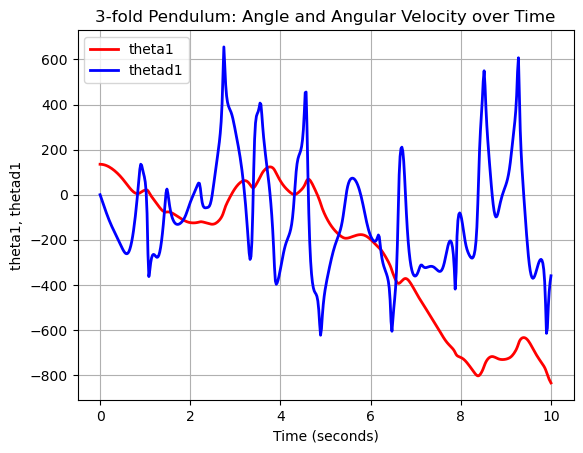


Note: thetad2 represents time derivative of theta2



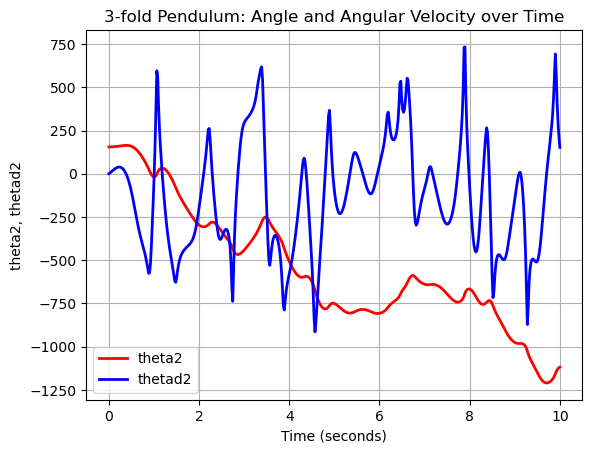


Note: thetad3 represents time derivative of theta3



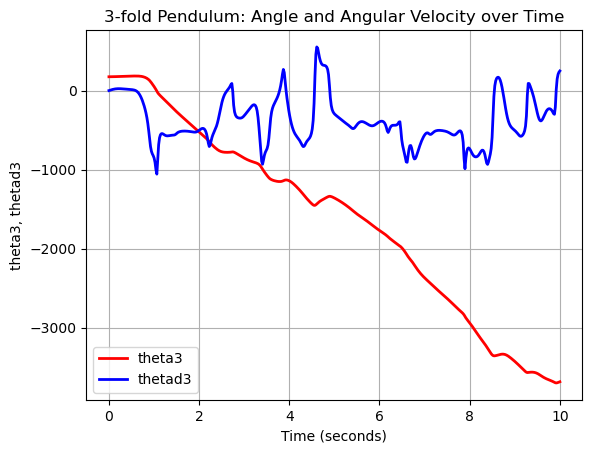

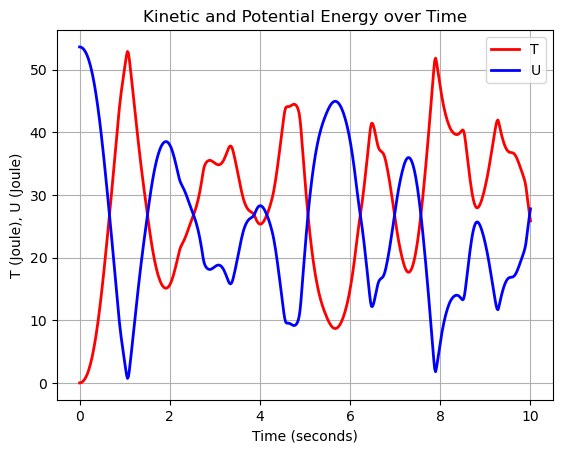

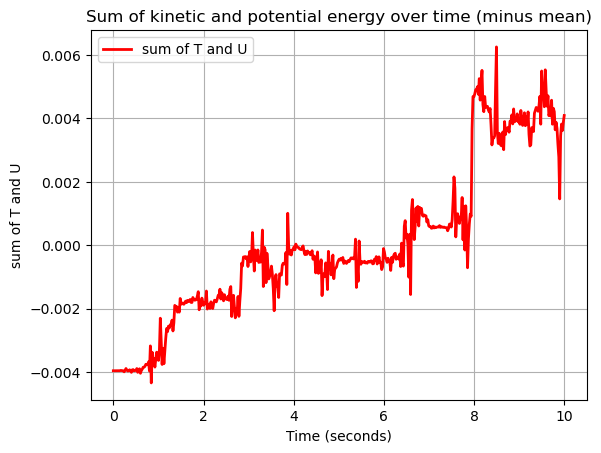


Mean of sum of T and U is: 53.616251610866136
Deviation is a maximum of 0.011665810098681903 percent in positive direction
Deviation is a maximum of 0.008103228476298229 percent in negative direction



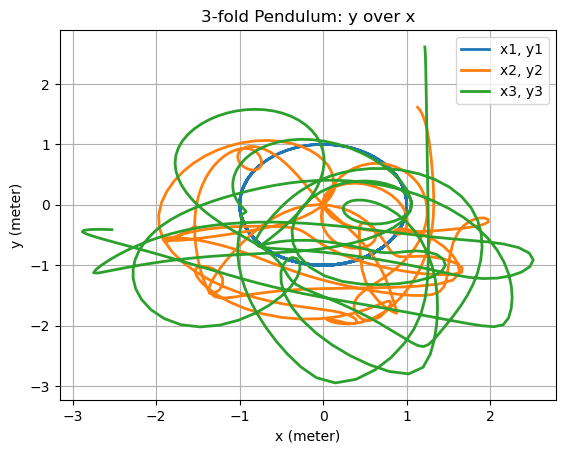

In [6]:

for i in range(N):
    # creation of labels
    var_name = variable_name + str(i+1)
    vard_name = variable_name + "d" + str(i+1)
    y_label = var_name +", " + vard_name

    # note for users because automtic labeling with tex symbols did not work
    print("")
    print("Note: " + vard_name + " represents time derivative of " + var_name)
    print("")
  
    # plot of angle and angular velocity over time
    plt.figure(i+1)
    plt.plot(tt, var_deg_array[2*i], 'r', lw=2, label=var_name)
    plt.plot(tt, var_deg_array[2*i+1], 'b', lw=2, label=vard_name)
    plt.title(str(N) + "-fold Pendulum: Angle and Angular Velocity over Time")
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel(y_label)
    plt.grid()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# plot of kinetic energy T and potential energy U over time
plt.figure(N+1)
plt.plot(tt, T_sol, 'r', lw=2, label='T')
plt.plot(tt, U_sol, 'b', lw=2, label='U')
plt.title('Kinetic and Potential Energy over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'T (Joule), U (Joule)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate mean from sum of T and U -> controll if numerical simulation was sucessful (great shifts would be a hint for bad simulation results)
# mean substracted in following plot to visualize only the deviation from zero -> ideally should be zero but small deviations are okay
mean_T_plus_U = np.mean(T_sol+U_sol)

# plot of deviation of sum of T and U over time
plt.figure(N+2)
plt.plot(tt, T_sol + U_sol - mean_T_plus_U, 'r', lw=2, label='sum of T and U')
plt.title('Sum of kinetic and potential energy over time (minus mean)')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('sum of T and U')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# determine maximum positive and negative deviation; return both values as a positive percent value
max_error = (abs(max(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100
min_error = (abs(min(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100

print("")
print("Mean of sum of T and U is:", mean_T_plus_U)
print("Deviation is a maximum of", max_error, "percent in positive direction")
print("Deviation is a maximum of", min_error, "percent in negative direction")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# y over x values
plt.figure(N+3)
for i in range(N):
    label_loop = 'x' + str(i+1) + ', y' + str(i+1)
    plt.plot(x_array[i], y_array[i], lw=2, label=label_loop)
title = str(N) + '-fold Pendulum: y over x'
plt.title(title)
plt.legend()
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.grid()
plt.show()


In [7]:

# animation of angles over time; angels are drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate animation
ani_ang = animate_ang(var_deg_array)

# open animation with this line
HTML(ani_ang.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani_ang.save("N-fold_Pendulum_angle.gif", dpi=300, writer=PillowWriter(fps=50))


In [8]:

# animation of angular velocity over time; angular velocitys are drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate animation
ani_ang_vel = animate_ang_vel(var_deg_array)

# open animation with this line
HTML(ani_ang_vel.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani_ang_vel.save("N-fold_Pendulum_angular_velocity.gif", dpi=300, writer=PillowWriter(fps=50))


In [9]:

# animation of pendulum motion over time; motion is drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages 
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# extract angels from res.y and write in array var_array
var_array = []
for i in range(N):
    var_temp = res.y[2*i]
    var_array.append(var_temp)

# calculates sum of all length; used for scaling of plot
sum_length = sum(l_par)

# calculates all x and y values from angles and lengths
x_array, y_array = pend_pos(var_array)

# calculate animation
anim = animate_pendulum(x_array, y_array)

# open animation with this line
HTML(anim.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
anim.save("N-fold_Pendulum_motion.gif", dpi=300, writer=PillowWriter(fps=50))
